In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-hiring-tests/dataset/sample_submission.csv
/kaggle/input/shl-hiring-tests/dataset/train.csv
/kaggle/input/shl-hiring-tests/dataset/test.csv
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_885.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_698.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_66.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_386.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_330.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_72.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_858.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_107.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_820.wav
/kaggle/input/shl-hiring-tests/dataset/audios_test/audio_300.

# SHL Assessment

**I have implemented 2 strategies that I am presenting in this notebook:**
- Extracting audio embeddings and ML models for score prediction (Pearson Correlation : 0.772)
- Extracting transcription and applied Bert model (Pearson Correlation : 0.739)

# 1st Approach <br> 

A pipeline for grammar score prediction from spoken audio using Wav2Vec2 embeddings and ML models. Here's a step-by-step breakdown of the process shown in the diagram:

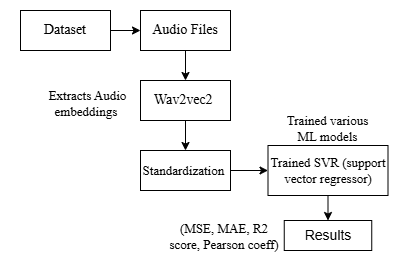 <br> 

1) **Dataset** : Contains metadata such as filenames and corresponding grammar score labels.
2) **Audio Files** : Actual speech recordings (.wav) corresponding to each entry in the dataset.
3) **Wav2Vec2** : A pretrained self-supervised audio model that transforms raw waveforms into dense feature embeddings. These embeddings capture semantic and acoustic characteristics of the audio. <br> 
**Output**: A fixed-size feature vector per audio sample.
4) **Standardization** : Feature scaling step to ensure all features have zero mean and unit variance.
5) **Trained SVR (Support Vector Regressor)** : The standardized Wav2Vec2 embeddings are fed into varoius ML models.
6) **Results** : Model performance is evaluated
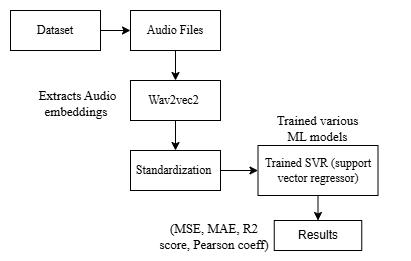

In [34]:
!pip install pandas librosa torchaudio transformers tqdm

In [35]:

# Load and Explore the Dataset
import os
import torch
import pandas as pd
import torchaudio
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Load training metadata
train_df = pd.read_csv('/kaggle/input/shl-hiring-tests/dataset/train.csv')  # Adjust filename as needed
audio_dir = "/kaggle/input/shl-hiring-tests/dataset/audios_train"

# Explore the training data
print(f"Training samples: {len(train_df)}")
print(f"Score distribution:\n{train_df['label'].value_counts().sort_index()}")
print(f"Score range: {train_df['label'].min()} - {train_df['label'].max()}")

Training samples: 444
Score distribution:
label
1.0      1
1.5      3
2.0     70
2.5     40
3.0     87
3.5     23
4.0     52
4.5     58
5.0    110
Name: count, dtype: int64
Score range: 1.0 - 5.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


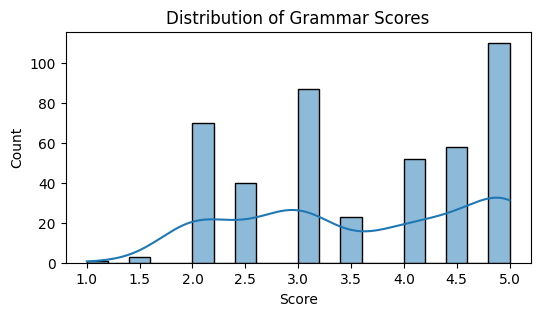

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize score distribution
plt.figure(figsize=(6, 3))
sns.histplot(train_df['label'], bins=20, kde=True)
plt.title('Distribution of Grammar Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [49]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model

#Load processor and model (no tokenizer needed for Wav2Vec2)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [50]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [51]:
#audio loading & feature extraction
def load_audio(file_path, sample_rate=16000):
    waveform, sr = torchaudio.load(file_path)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    waveform = waveform.mean(dim=0)  # convert to mono if stereo
    return waveform.numpy()  # return 1D numpy array

In [52]:
def extract_wav2vec2_embedding(waveform):   #extract mean Wav2Vec2 embeddings from the waveform.
    # waveform is a 1D numpy array
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(device)  # shape: [1, time]
    
    with torch.no_grad():
        outputs = model(input_values)

    # Average pooling across time dimension
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embeddings


In [41]:
# === Extract Features for All Training Audio ===
features = []
labels = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(audio_dir, row['filename'])
    waveform = load_audio(file_path)
    embedding = extract_wav2vec2_embedding(waveform)
    features.append(embedding)
    labels.append(row['label'])

100%|██████████| 444/444 [02:34<00:00,  2.88it/s]


In [42]:
# === Convert to NumPy Arrays ===
import numpy as np
X = np.array(features)
y = np.array(labels)

# Data Set Preparation

In [43]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 355
Validation set size: 89


In [44]:
# Train Regression Models (Baseline)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor  # ✅ XGBoost import

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np

def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Clip predictions to valid range [0, 5]
    y_pred = np.clip(y_pred, 0, 5)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    pearson_corr, _ = pearsonr(y_val, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")

    return mse, mae, r2, pearson_corr, model


# Try different regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}

results = {}



In [46]:
print("Evaluating regression models...")
for name, model in models.items():
    print(f"\n{name}:")
    mse, mae, r2, pearson_corr, trained_model = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val)
    results[name] = {"model": trained_model, "mse": mse, "mae": mae, "r2": r2}

# Select the best model based on MSE
best_model_name = min(results, key=lambda x: results[x]["mse"])
best_model = results[best_model_name]["model"]
print(f"\nBest model: {best_model_name} with MSE: {results[best_model_name]['mse']:.4f}")

Evaluating regression models...

Linear Regression:
MSE: 1.1194
MAE: 0.7013
R²: 0.1788
Pearson Correlation: 0.6056

Ridge Regression:
MSE: 0.9481
MAE: 0.6455
R²: 0.3045
Pearson Correlation: 0.6369

SVR:
MSE: 0.5473
MAE: 0.5963
R²: 0.5985
Pearson Correlation: 0.7837

Random Forest:
MSE: 0.7364
MAE: 0.7200
R²: 0.4598
Pearson Correlation: 0.7095

Gradient Boosting:
MSE: 0.6811
MAE: 0.6694
R²: 0.5003
Pearson Correlation: 0.7185

XGBoost:
MSE: 0.6991
MAE: 0.6776
R²: 0.4871
Pearson Correlation: 0.7127

Best model: SVR with MSE: 0.5473


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

#hyperparameter Tuning (SVR)
param_grid = {
    'kernel': ['rbf', 'linear'],            # Try different kernels
    'C': [0.1, 1, 10, 100],                 # Regularization strength
    'epsilon': [0.01, 0.1, 0.2],            # Insensitive loss margin
    'gamma': ['scale', 'auto']             # Kernel coefficient
}

# Grid search setup
grid_search = GridSearchCV(
    SVR(),                     # SVR model
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on validation set
y_pred = best_model.predict(X_val_scaled)
y_pred = np.clip(y_pred, 0, 5)  # Clip to valid range

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Fine-tuned model performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Fine-tuned model performance:
MSE: 0.4463
MAE: 0.4994
R²: 0.6726


In [53]:
# Load test data
test_df = pd.read_csv('/kaggle/input/shl-hiring-tests/dataset/test.csv')
test_audio_dir = "/kaggle/input/shl-hiring-tests/dataset/audios_test"

print(f"Test samples: {len(test_df)}")

# Extract features for test data
test_features = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(test_audio_dir, row['filename'])
    waveform = load_audio(file_path)
    embedding = extract_wav2vec2_embedding(waveform)
    test_features.append(embedding)

X_test = np.array(test_features)
X_test_scaled = scaler.transform(X_test)  # Scale using the same scaler

# Make predictions
test_predictions = best_model.predict(X_test_scaled)
test_predictions = np.clip(test_predictions, 0, 5)  # Clip to valid range

# Save predictions to CSV
test_df['label'] = test_predictions

Test samples: 195


100%|██████████| 195/195 [01:03<00:00,  3.07it/s]


In [54]:
test_df.head(10)

,filename,label
0,audio_706.wav,2.471994
1,audio_800.wav,2.611242
2,audio_68.wav,3.235404
3,audio_1267.wav,3.368394
4,audio_683.wav,2.201790
5,audio_1242.wav,2.364693
6,audio_908.wav,2.973348
7,audio_888.wav,3.265724
8,audio_137.wav,3.392523
9,audio_770.wav,2.255207


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


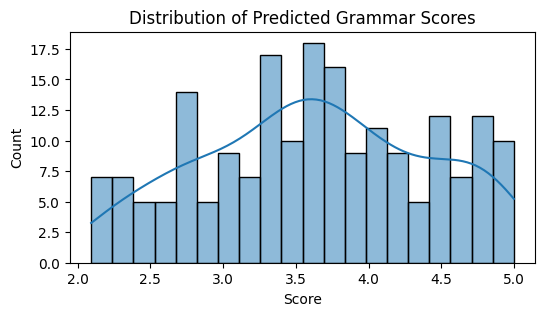

In [55]:
# Visualize score distribution
plt.figure(figsize=(6, 3))
sns.histplot(test_df['label'], bins=20, kde=True)
plt.title('Distribution of Predicted Grammar Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [ ]:
test_df[['filename', 'label']].to_csv('predictions_19.csv', index=False)
print("Predictions saved to 'predictions_13.csv'")

# 2nd Approach <br>

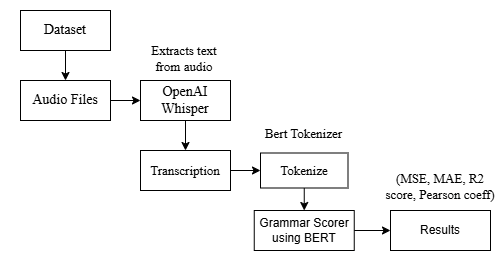

1) **Dataset Input** : The system starts with a dataset consisting of audio files.
2) **Speech-to-Text Conversion** : Audio files are passed through OpenAI Whisper, an automatic speech recognition (ASR) model. <br>
**Output**: Transcription – the spoken content is converted into text.
3) **Text Tokenization** : The transcribed text is then processed using a BERT tokenizer, which converts raw text into token IDs suitable for input to a BERT model.
4) **Grammar Scoring** : The tokenized text is passed to a BERT-based model trained for grammar scoring. This model predicts a grammar quality score for each transcription (on a scale such as 0–5).
5) **Results** : The evaluation metrics are used to assess how well the grammar scorer performs, providing insights into model accuracy and reliability.

**Note** : I also tried using wav2vec2 for transcribing the audio files, but the results were not satisfactory. The transcription quality was poor, leading to inaccurate grammar scoring. Therefore, I opted for OpenAI Whisper for better transcription accuracy.

In [57]:
import pandas as pd
import os

# Load training data
train_df = pd.read_csv('/kaggle/input/shl-hiring-tests/dataset/train.csv')

# Display the first few rows and basic information
print("Training dataset head:")
print(train_df.head())
print("\nDataset info:")
print(train_df.info())

Training dataset head:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  444 non-null    object 
 1   label     444 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.1+ KB
None


In [58]:
# Check audio files
train_audio_dir = '/kaggle/input/shl-hiring-tests/dataset/audios_train'
print(f"\nSample audio files: {os.listdir(train_audio_dir)[:5]}")
print(f"Total audio files: {len(os.listdir(train_audio_dir))}")

# Verify audio file existence for a few samples
sample_files = train_df['filename'].head(3).tolist()
for file in sample_files:
    full_path = os.path.join(train_audio_dir, file)
    print(f"File {file}: {'Exists' if os.path.exists(full_path) else 'Not found'}")


Sample audio files: ['audio_90.wav', 'audio_581.wav', 'audio_77.wav', 'audio_817.wav', 'audio_694.wav']
Total audio files: 444
File audio_1261.wav: Exists
File audio_942.wav: Exists
File audio_1110.wav: Exists


In [60]:
import os
import pandas as pd
import torch
import librosa
from tqdm import tqdm
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import numpy as np

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

In [61]:
def transcribe_dataset(csv_path, audio_dir, output_csv=None, model_name="openai/whisper-large-v3"):
    # Load CSV containing audio filenames
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} entries from {csv_path}")
    
    # Use GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Load Whisper model and processor
    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
    
    transcriptions = []
    failed_files = []
    
    # Loop through each audio file
    for idx, filename in tqdm(enumerate(df['filename']), total=len(df)):
        try:
            audio_path = os.path.join(audio_dir, filename)
            
            # Load audio with librosa at 16kHz
            audio, sr = librosa.load(audio_path, sr=16000)
            
            # Convert to float32 for model compatibility
            if audio.dtype != np.float32:
                audio = audio.astype(np.float32)
            
            # Handle empty audio
            if len(audio) == 0:
                print(f"Warning: Empty audio file {filename}")
                transcriptions.append("")
                failed_files.append(filename)
                continue
            
            # Preprocess input for Whisper
            input_features = processor(
                audio, 
                sampling_rate=16000, 
                return_tensors="pt", 
                return_attention_mask=True
            ).to(device)
            
            # Generate transcription using forced English decoding
            with torch.no_grad():
                forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")
                predicted_ids = model.generate(
                    input_features.input_features,
                    attention_mask=input_features.attention_mask,
                    forced_decoder_ids=forced_decoder_ids,
                    max_length=448
                )
            
            # Decode prediction to text
            transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
            
            # Remove non-ASCII characters
            transcription = ''.join(c if ord(c) < 128 else ' ' for c in transcription)
            
            transcriptions.append(transcription)
            
            if idx % 50 == 0:
                print(f"Sample transcription ({filename}): {transcription}")
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            transcriptions.append("")
            failed_files.append(filename)
    
    # Add transcriptions to dataframe
    df['transcription'] = transcriptions
    
    # Save updated CSV if requested
    if output_csv:
        df.to_csv(output_csv, index=False)
        print(f"Saved transcriptions to {output_csv}")
        
    # Print failed file summary
    if failed_files:
        print(f"Failed to process {len(failed_files)} files:")
        for f in failed_files[:10]:
            print(f"  - {f}")
        if len(failed_files) > 10:
            print(f"  - ... and {len(failed_files) - 10} more")
    
    return df


In [62]:
transcriptions_train = transcribe_dataset('/kaggle/input/shl-hiring-tests/dataset/train.csv', '/kaggle/input/shl-hiring-tests/dataset/audios_train', 'transcriptions_train_2.csv')
transcriptions_test = transcribe_dataset('/kaggle/input/shl-hiring-tests/dataset/test.csv', '/kaggle/input/shl-hiring-tests/dataset/audios_test', 'transcriptions_test_2.csv')

Loaded 444 entries from /kaggle/input/shl-hiring-tests/dataset/train.csv
Using device: cuda


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

  0%|          | 1/444 [00:20<2:31:45, 20.55s/it]

Sample transcription (audio_1261.wav):  Thank you.


 11%|█▏        | 51/444 [01:49<12:45,  1.95s/it] 

Sample transcription (audio_244.wav):  My favorite hobby is watching movies. So watching movies is just like to entertain ourselves or to relieve from tension or stress. So majority watch movies so well in holidays or vacations. But my hobby is to watch in while exams because while examinations brain is all about the tension or think about exams only. But if I believe in that at that time if you watch and


 23%|██▎       | 101/444 [03:21<10:56,  1.91s/it]

Sample transcription (audio_1028.wav):  My favorite place to visit Kerala and it's so beautiful with greenery and boat traveling and there are many famous places like vineyard somewhere like with full of greenery and nature with peaceful mind and there was many fruits like they prepare with coconut


 34%|███▍      | 151/444 [04:49<07:21,  1.51s/it]

Sample transcription (audio_827.wav):  uh


 45%|████▌     | 201/444 [06:24<06:54,  1.71s/it]

Sample transcription (audio_721.wav):  it is a center of attraction for both buyers and sellers there is no other place in the area having so such risky business as the market i always find a big crowd there there are usually shops or decorate all decorated beautifully uh so usually the markets are very busy and crowded um it is very difficult to


 57%|█████▋    | 251/444 [08:04<06:25,  1.99s/it]

Sample transcription (audio_188.wav):  My favorite hobby is painting. I really enjoy putting a paintbrush to a canvas and seeing what happens. I am not trained in any way, so things


 68%|██████▊   | 301/444 [09:34<04:08,  1.74s/it]

Sample transcription (audio_558.wav):  What I do on this... ...luxury... ...life... ...is... ...a... ...luxury... ...life... ...life...


 79%|███████▉  | 351/444 [10:58<03:21,  2.17s/it]

Sample transcription (audio_516.wav):  I love going to the beach. The beach in Costa Rica is one of my favorite places to travel to. Although it is not a white sand beach, the water is fairly calm and it is always warm. There are also food stations scattered around the beach which makes it easy to spend all day there. The people are friendly and there's always something to do. It is also very safe. If you want to, you can explore the beach and see all different types of wildlife including birds and occasionally


 90%|█████████ | 401/444 [12:43<01:26,  2.00s/it]

Sample transcription (audio_489.wav):  Let's see. My favorite place to visit would be St. Augustine. We generally just drive there because it's a few minutes away. Not a few minutes. It's a few hours away. So it's not that hard of a drive. We like to go before it gets too hot in Florida. And we just walk around the main strip that has all of the boutique shops. And we eat and we go to our favorite restaurant.


100%|██████████| 444/444 [13:59<00:00,  1.89s/it]


Saved transcriptions to transcriptions_train_2.csv
Loaded 195 entries from /kaggle/input/shl-hiring-tests/dataset/test.csv
Using device: cuda


  1%|          | 1/195 [00:01<03:42,  1.15s/it]

Sample transcription (audio_706.wav):  Okay, I'll write it down. What are you doing? Why did you call me on the phone? You!


 26%|██▌       | 51/195 [01:36<04:19,  1.80s/it]

Sample transcription (audio_920.wav):  My best day of my life is my 20th birthday because on that day everyone in my family, my close relatives, my friends were all together to celebrate my 20th birthday. And it was the best day because it creates so many nice memories that always makes me so lucky that


 52%|█████▏    | 101/195 [03:13<02:32,  1.62s/it]

Sample transcription (audio_103.wav):  I hope that that's all.


 77%|███████▋  | 151/195 [04:45<01:21,  1.84s/it]

Sample transcription (audio_386.wav):  I


100%|██████████| 195/195 [06:09<00:00,  1.89s/it]

Saved transcriptions to transcriptions_test_2.csv


In [63]:
# Load the processed training CSV
train_df = pd.read_csv("/kaggle/working/transcriptions_train_2.csv")
train_df.sample(5)

,filename,label,transcription
242,audio_611.wav,4.5,You have been so cold to me since I last saw ...
153,audio_93.wav,3.0,This market is very popular in the city. You ...
354,audio_1160.wav,5.0,"One day one year, I was a little boy. I was a..."
272,audio_469.wav,4.0,I
134,audio_346.wav,3.0,"In my life, the best day is my enjoying the d..."


In [68]:
train_df.iloc[5]['transcription']

' Best day in life is earning money. For everyone its money is most important. So earning ourself is a thing when we start earning. So actually to earn money we have to know some skills. Even if we need money or to earn money we must complete our graduation or studies or need some skills. But if we earn money while we are educating like even in school times. So it'

In [70]:
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertModel,
    BertConfig,
    AdamW,
    get_scheduler
)
import torch.nn as nn


In [71]:
#Custom Dataset Class for Grammar Scoring
class GrammarDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = self.tokenizer(
            row['transcription'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Flatten the batch dimension
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(row['label'], dtype=torch.float)
        return item


In [72]:
class GrammarScorer(nn.Module):   #BERT-based Grammar Scorer (Regression Model)
    def __init__(self):
        super(GrammarScorer, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output  # Use [CLS] token representation
        score = self.regressor(cls_output)  # Predict grammar score
        return score.squeeze(-1)


In [73]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import numpy as np
import torch.nn as nn

# Split into training and testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create datasets and data loaders
train_dataset = GrammarDataset(train_df, tokenizer)
test_dataset = GrammarDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [74]:
# Initialize model and optimizer
model = GrammarScorer().cuda()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Linear LR scheduler
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss function: Mean Squared Error
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {total_loss/len(train_loader):.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 45/45 [00:09<00:00,  4.58it/s]


Epoch 1 - Training Loss: 3.2999


100%|██████████| 45/45 [00:09<00:00,  4.64it/s]


Epoch 2 - Training Loss: 0.8964


100%|██████████| 45/45 [00:09<00:00,  4.64it/s]


Epoch 3 - Training Loss: 0.5216


100%|██████████| 45/45 [00:09<00:00,  4.64it/s]


Epoch 4 - Training Loss: 0.3782


100%|██████████| 45/45 [00:09<00:00,  4.65it/s]


Epoch 5 - Training Loss: 0.2779


100%|██████████| 45/45 [00:09<00:00,  4.64it/s]


Epoch 6 - Training Loss: 0.2002


100%|██████████| 45/45 [00:09<00:00,  4.65it/s]


Epoch 7 - Training Loss: 0.1957


100%|██████████| 45/45 [00:09<00:00,  4.65it/s]


Epoch 8 - Training Loss: 0.1430


100%|██████████| 45/45 [00:09<00:00,  4.66it/s]


Epoch 9 - Training Loss: 0.1516


100%|██████████| 45/45 [00:09<00:00,  4.64it/s]

Epoch 10 - Training Loss: 0.1263


In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set model to evaluation mode
model.eval()
predictions = []
true_labels = []

# Inference loop
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cpu().numpy()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).cpu().numpy()

        predictions.extend(outputs)
        true_labels.extend(labels)

# Calculate and print metrics
mae = mean_absolute_error(true_labels, predictions)
mse = mean_squared_error(true_labels, predictions)

print(f"Test MAE: {mae:.3f}")
print(f"Test MSE: {mse:.3f}")


Test MAE: 0.674
Test MSE: 0.935


In [76]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from tqdm import tqdm

# Load test file
test_path = "/kaggle/working/transcriptions_test_2.csv"
test_df = pd.read_csv(test_path)

test_df.head()


,filename,transcription
0,audio_706.wav,"Okay, I'll write it down. What are you doing?..."
1,audio_800.wav,My hobbies are playing cricket because I am a...
2,audio_68.wav,"Yes, at this market you can find a lot of thi..."
3,audio_1267.wav,"My goal is I become an interpreter, entrepren..."
4,audio_683.wav,okay in in code market there's a lot of peopl...


In [77]:
# Check required columns
assert 'filename' in test_df.columns, "'filename' column missing"
assert 'transcription' in test_df.columns, "'transcription' column missing"

# Load tokenizer (same as training)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset class for test
class InferenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=200):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        transcription = self.data.iloc[idx]['transcription']
        encoding = self.tokenizer(
            transcription,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# Create DataLoader
inference_dataset = InferenceDataset(test_df, tokenizer)
inference_loader = DataLoader(inference_dataset, batch_size=8, shuffle=False)

# Run inference
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(inference_loader):
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask).cpu().numpy()
        predictions.extend(outputs)

# Clip predictions to valid range (1 to 5)
predictions = np.clip(predictions, 1, 5)



100%|██████████| 25/25 [00:01<00:00, 16.87it/s]


In [78]:
# Add predictions to dataframe
test_df['label'] = np.round(predictions, 2)  # You can also round to nearest int if needed

# Save result
save_path = "/kaggle/working/predictions_11.csv"
test_df[['filename', 'label']].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: /kaggle/working/predictions_11.csv


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


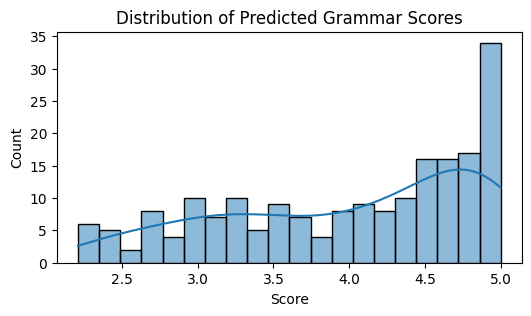

In [80]:
# Visualize score distribution
plt.figure(figsize=(6, 3))
sns.histplot(test_df['label'], bins=20, kde=True)
plt.title('Distribution of Predicted Grammar Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()